# Introduction

author: Mengliu Zhao\
date: July 27, 2024\
github: https://github.com/adoskk

Main method used in this notebook: **SimSiam**\
Ref: Chen et al., Exploring Simple Siamese Representation Learning. CVPR 2021. \
Link: https://arxiv.org/pdf/2011.10566

Comparing to SimCLR, SimSiam has the advantages of smaller batch sizes because it doesn't rely on negative pairs:
| Method | Need Hard Negative Mining | Contrastive Loss | Recommended Batch Size | Optimizer |
| ---    |  ---                      | ---              | ---                     | ---      |
| SimCLR | Yes                       | NT-Xent loss     |  4096                   | LARS     |
| SimSiam| No                        | Cosine Similarity Loss | 512               | SGD      | 

This notebook creates a simple example for showcasing how to use SimSiam in FashionMNIST classification. 

1. A baseline classification model is trained for supervised classification purpose
2. The same classification model is re-trained in fully supervised-style on a limited training set (~2% of labels), showing the effect of lack of annotations
3. The model is trained on the full training set in SimSiam-style without using any labels 
4. The backbone of the SimSiam model is frozen and the linear layers are finetuned on the limited training set 
4. The SimSiam-style model shows ~15% of improvement over F1-score and recall comparing to #2

# 0. Preparing Dataset
1. train_dataset：The full training set for FashionMNIST containing 60,000 images and labels
2. test_dataset: The full testing set for FashionMNIST containing 10,000 images and labels
3. finetune_dataset: a subset extracted from train_dataset containing only 1,000 images and labels

Each image is grayscale with size (28, 28), the target class is between {0, ..., 9}

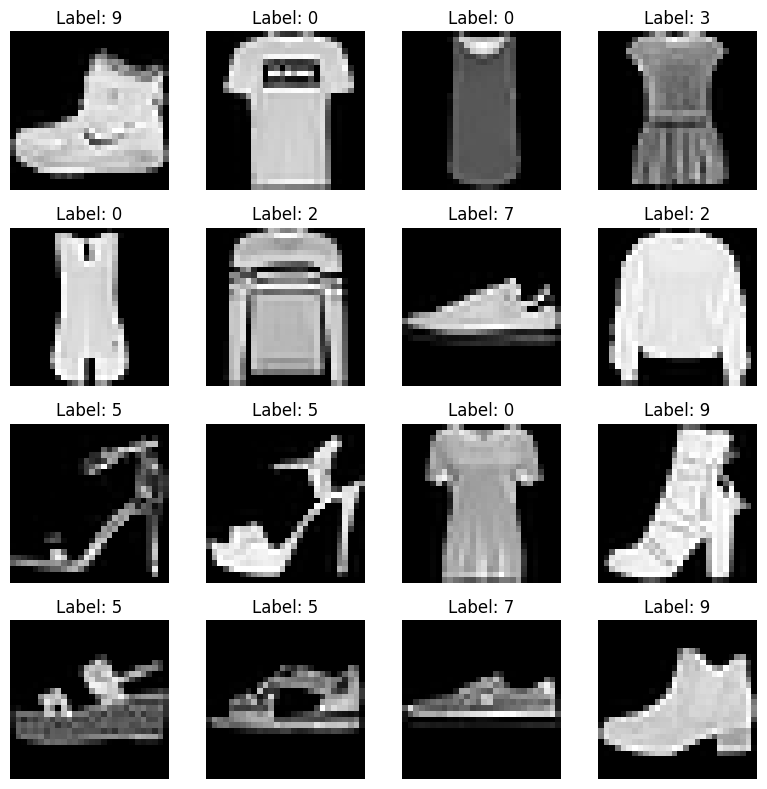

In [65]:
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

train_dataset = FashionMNIST("./FashionMNIST", 
                             train=True, 
                             transform=transforms.ToTensor(), 
                             download=True,
                             )
test_dataset = FashionMNIST("./FashionMNIST", 
                            train=False, 
                            transform=transforms.ToTensor(), 
                            download=True,
                            )
finetune_dataset = FashionMNIST("./FashionMNIST", 
                                train=True, 
                                transform=transforms.ToTensor(), 
                                download=True, 
                                first_k=1000,
                                )

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

In [13]:
print(len(train_dataset))
print(len(test_dataset))
print(len(finetune_dataset))
print(image.shape)

60000
10000
torch.Size([1, 28, 28])


# 1. Supervised Training

1. We set up a baseline supervised training model, which comprises a backbone of convolutional layers and a two-layer MLP.\
2. The model is trained for 10 total epochs using SGD optimizer.\
3. The classification report and some qualitative results are given.

In [14]:
import torch.nn as nn

class supervised_classification(nn.Module):
    
    def __init__(self):
        super(supervised_classification, self).__init__()
        
        self.backbone = nn.Sequential(
                                nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
        )
        
        self.fc = nn.Sequential(
                                nn.Linear(128*4*4, 32),
                                nn.ReLU(),
                                nn.Linear(32, 10),
        )
    
    def forward(self, x):
        x = self.backbone(x).view(-1, 128 * 4 * 4)
        
        return self.fc(x)

In [ ]:
import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import wandb

wandb_config = {
    "learning_rate": 0.001,
    "architecture": "fashion mnist classification full training",
    "dataset": "FashionMNIST",
    "epochs": 10,
    "batch_size": 64,
    }

wandb.init(
    # set the wandb project where this run will be logged
    project="supervised_classification",
    # track hyperparameters and run metadata
    config=wandb_config,
)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

supervised = supervised_classification()

optimizer = optim.SGD(supervised.parameters(), 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

train_dataloader = DataLoader(train_dataset, 
                              batch_size=wandb_config["batch_size"], 
                              shuffle=True,
                              )

# Training loop
loss_fun = nn.CrossEntropyLoss()
for epoch in range(wandb_config["epochs"]):
    supervised.train()
    
    train_loss = 0
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        optimizer.zero_grad()

        prediction = supervised(image)
                                
        loss = loss_fun(prediction, target)
        loss.backward()
        optimizer.step()
                
        wandb.log({"training loss": loss})
        
torch.save(supervised.state_dict(), "weights/fully_supervised.pt")    
    

C:\Users\mengl\AppData\Local\Temp\ipykernel_31888\2295972116.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 313/313 [00:02<00:00, 127.76it/s]


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.84      0.84      1000
           3       0.94      0.88      0.90      1000
           4       0.79      0.89      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.76      0.69      0.72      1000
           7       0.96      0.95      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



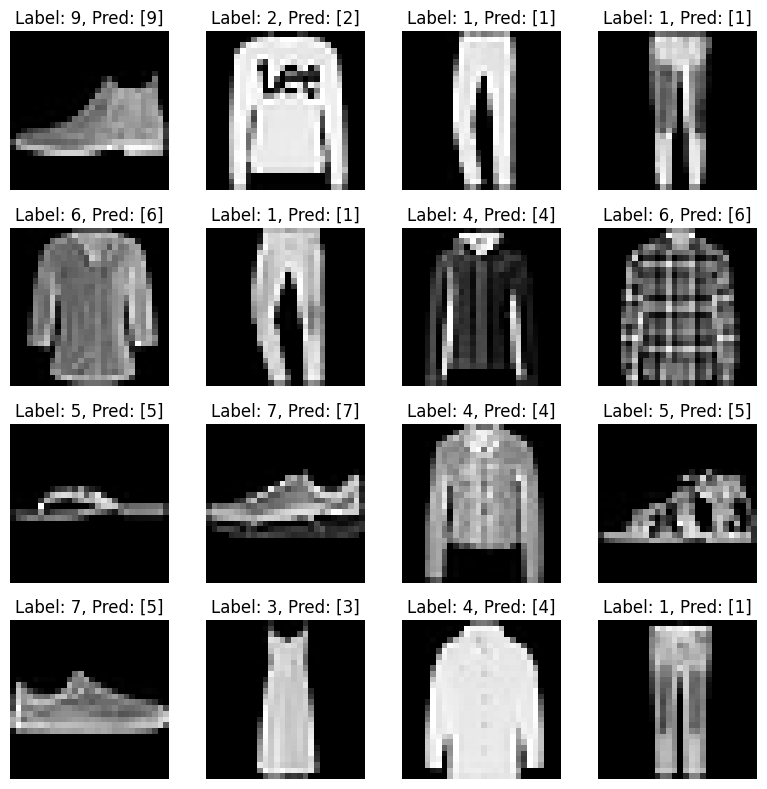

In [66]:
from sklearn.metrics import classification_report

supervised = supervised_classification()
                         
supervised.load_state_dict(torch.load("weights/fully_supervised.pt"))
supervised.eval()
supervised.to(device)

target_list = []
prediction_list = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    with torch.no_grad():
        prediction = supervised(image.to(device))
    
    prediction_list.extend(torch.argmax(prediction, dim=1).detach().cpu().numpy())
    target_list.extend(target.detach().cpu().numpy())

print(classification_report(target_list, prediction_list))

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = test_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        prediction = supervised(torch.unsqueeze(image, dim=0).to(device))
        prediction = torch.argmax(prediction, dim=1).detach().cpu().numpy()
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}, Pred: {prediction}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

# 2. Supervised Learning on a Limited Training Set

The same supervised classification model is trained on a limited dataset with only 1000 labels for 100 epochs.\
The average F1-score drops to 64%


In [ ]:
import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader


import wandb

wandb_config = {
    "learning_rate": 0.001,
    "architecture": "fashion mnist classification full training on finetune set",
    "dataset": "FashionMNIST",
    "epochs": 100,
    "batch_size": 64,
    }

wandb.init(
    # set the wandb project where this run will be logged
    project="supervised_classification",
    # track hyperparameters and run metadata
    config=wandb_config,
)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

supervised = supervised_classification()

optimizer = optim.SGD(supervised.parameters(), 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

finetune_dataloader = DataLoader(finetune_dataset, 
                                 batch_size=wandb_config["batch_size"], 
                                 shuffle=True,
                                 )

# Training loop
loss_fun = nn.CrossEntropyLoss()
for epoch in range(wandb_config["epochs"]):
    supervised.train()
    
    train_loss = 0
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(finetune_dataloader, total=len(finetune_dataloader))):
        optimizer.zero_grad()

        prediction = supervised(image)
                                
        loss = loss_fun(prediction, target)
        loss.backward()
        optimizer.step()
                
        wandb.log({"training loss": loss})
        
torch.save(supervised.state_dict(), "weights/fully_supervised_finetunedataset.pt")    
    

C:\Users\mengl\AppData\Local\Temp\ipykernel_31888\1041090414.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 313/313 [00:02<00:00, 127.55it/s]


              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1000
           1       0.99      0.86      0.92      1000
           2       0.50      0.44      0.47      1000
           3       0.71      0.82      0.76      1000
           4       0.45      0.56      0.50      1000
           5       0.75      0.76      0.75      1000
           6       0.35      0.43      0.39      1000
           7       0.70      0.80      0.75      1000
           8       0.98      0.28      0.44      1000
           9       0.74      0.92      0.82      1000

    accuracy                           0.65     10000
   macro avg       0.68      0.65      0.64     10000
weighted avg       0.68      0.65      0.64     10000



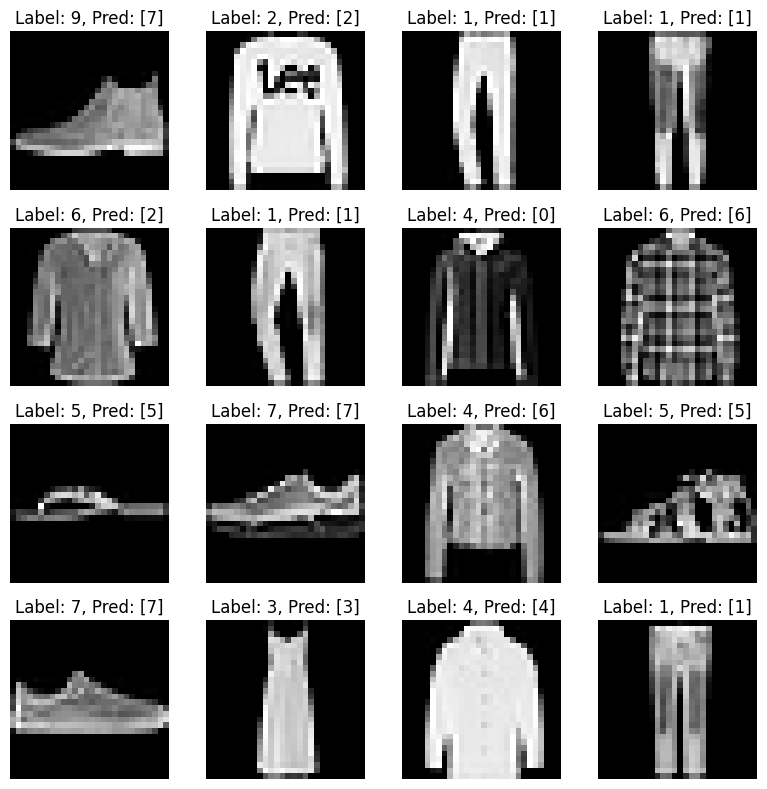

In [67]:
from sklearn.metrics import classification_report

supervised = supervised_classification()
                         
supervised.load_state_dict(torch.load("weights/fully_supervised_finetunedataset.pt"))
supervised.eval()
supervised.to(device)

target_list = []
prediction_list = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    with torch.no_grad():
        prediction = supervised(image.to(device))
    
    prediction_list.extend(torch.argmax(prediction, dim=1).detach().cpu().numpy())
    target_list.extend(target.detach().cpu().numpy())

print(classification_report(target_list, prediction_list))

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = test_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        prediction = supervised(torch.unsqueeze(image, dim=0).to(device))
        prediction = torch.argmax(prediction, dim=1).detach().cpu().numpy()
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}, Pred: {prediction}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

# 3. SimSiam Model
The output dimension of the MLP layer for the SimSiam model needs to match with the backbone output dimension, for the cosine similariy loss calculation.\
For simplicity, we ignored the MLP layers suggested in the original SimSiam paper. Instead, we simply use a convolutional-based backbone.\
For a fair comparison, we keep most of the configurations comparable to #2, e.g., both epoch = 100, using SGD as optimizer.\
Then we show the SimSiam feature representation on the testing test using UMAP dimension reduction.

In [41]:
import torch.nn as nn
import matplotlib.pyplot as plt


class SimSiam(nn.Module):
    
    def __init__(self):
        
        super(SimSiam, self).__init__()
        
        self.backbone = nn.Sequential(
                                nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
        )
        
        self.prediction_mlp = nn.Sequential(nn.Linear(128*4*4, 64),
                               nn.BatchNorm1d(64),
                               nn.ReLU(),
                               nn.Linear(64, 128*4*4),
        )

    def forward(self, x):
        x = self.backbone(x)
        
        x = x.view(-1, 128 * 4 * 4)
        pred_output = self.prediction_mlp(x)
        return x, pred_output
    
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def negative_cosine_similarity_stopgradient(pred, proj):
    return -cos(pred, proj.detach()).mean()


In [ ]:
import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import RandAugment

import wandb

wandb_config = {
    "learning_rate": 0.0001,
    "architecture": "simsiam",
    "dataset": "FashionMNIST",
    "epochs": 100,
    "batch_size": 256,
    }

wandb.init(
    # set the wandb project where this run will be logged
    project="simsiam",
    # track hyperparameters and run metadata
    config=wandb_config,
)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

simsiam = SimSiam()

random_augmenter = RandAugment(num_ops=5)

optimizer = optim.SGD(simsiam.parameters(), 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

train_dataloader = DataLoader(train_dataset, batch_size=wandb_config["batch_size"], shuffle=True)

# Training loop
for epoch in range(wandb_config["epochs"]):
    simsiam.train()
    
    print(f"Epoch {epoch}")
    train_loss = 0
    for batch_idx, (image, _) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        optimizer.zero_grad()
        
        aug1, aug2 = random_augmenter((image*255).to(dtype=torch.uint8)).to(dtype=torch.float32) / 255.0, \
                        random_augmenter((image*255).to(dtype=torch.uint8)).to(dtype=torch.float32) / 255.0
                        
        proj1, pred1 = simsiam(aug1)
        proj2, pred2 = simsiam(aug2)
                                
        loss = negative_cosine_similarity_stopgradient(pred1, proj2) / 2 + negative_cosine_similarity_stopgradient(pred2, proj1) / 2
        loss.backward()
        optimizer.step()
                
        wandb.log({"training loss": loss})
        
    if (epoch+1) % 10 == 0:
        torch.save(simsiam.state_dict(), f"weights/simsiam_epoch{epoch+1}.pt")    
    

In [44]:
import tqdm
import numpy as np

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

simsiam = SimSiam()                      

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
simsiam.load_state_dict(torch.load("weights/simsiam_epoch100.pt"))

simsiam.eval()
simsiam.to(device)

features = []
labels = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    
    with torch.no_grad():
    
        proj, pred = simsiam(image.to(device))
        
    features.extend(np.squeeze(pred.detach().cpu().numpy()).tolist())
    labels.extend(target.detach().cpu().numpy().tolist())

C:\Users\mengl\AppData\Local\Temp\ipykernel_31888\2960030196.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 313/313 [00:03<00:00, 92.45it/s]


In [45]:
import plotly.express as px
import umap.umap_ as umap

reducer = umap.UMAP(n_components=3, n_neighbors=10, metric="cosine")
projections = reducer.fit_transform(np.array(features))

px.scatter(projections, x=0, y=1,
    color=labels, labels={'color': 'Fashion MNIST Labels'}
)
# fig.show()

# 4. Finetune the SimSiam Backbone on the Limited Labelled Training Set
The SimSiam only provides a training strategy to learn the representation from the unlabelled set and has to be finetuned for a downstream task.\
We load the backbone weights into the baseline classification model, freeze the backbone weights, and only finetune the linear layers.\
The evaluation shows the finetuned model reaches 15% increase of F1-score on the testing set.

In [ ]:
import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import wandb

wandb_config = {
    "learning_rate": 0.001,
    "architecture": "supervised learning with simsiam backbone",
    "dataset": "FashionMNIST",
    "epochs": 100,
    "batch_size": 64,
    }
wandb.init(
    # set the wandb project where this run will be logged
    project="simsiam-finetune",
    # track hyperparameters and run metadata
    config=wandb_config,
)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

supervised = supervised_classification()
                         
model_dict = supervised.state_dict()
simsiam_dict = {k: v for k, v in model_dict.items() if k in torch.load("simsiam.pt")}
supervised.load_state_dict(simsiam_dict, strict=False)

finetune_dataloader = DataLoader(finetune_dataset, batch_size=32, shuffle=True)

for param in supervised.backbone.parameters():
    param.requires_grad = False
parameters = [para for para in supervised.parameters() if para.requires_grad]
optimizer = optim.SGD(parameters, 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

# Training loop
for epoch in range(wandb_config["epochs"]):
    supervised.train()
    
    train_loss = 0
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(finetune_dataloader)):
        optimizer.zero_grad()
        
        prediction = supervised(image)
        
        loss = nn.CrossEntropyLoss()(prediction, target)
        loss.backward()
        optimizer.step()
                
        wandb.log({"training loss": loss})
        
torch.save(supervised.state_dict(), "weights/supervised_with_simsiam.pt")
    
    

C:\Users\mengl\AppData\Local\Temp\ipykernel_31888\2049680141.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 313/313 [00:02<00:00, 125.80it/s]


              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.95      0.92      0.94      1000
           2       0.63      0.67      0.65      1000
           3       0.82      0.80      0.81      1000
           4       0.63      0.69      0.66      1000
           5       0.91      0.88      0.89      1000
           6       0.51      0.47      0.49      1000
           7       0.87      0.85      0.86      1000
           8       0.93      0.90      0.92      1000
           9       0.87      0.95      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



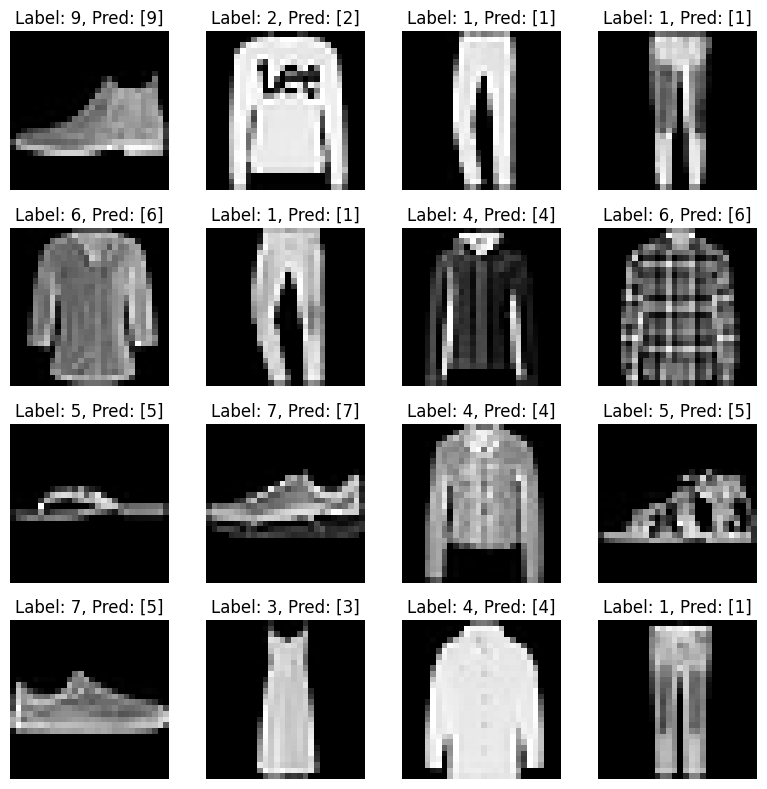

In [69]:
from sklearn.metrics import classification_report

supervised = supervised_classification()
                         
supervised.load_state_dict(torch.load("weights/supervised_with_simsiam.pt"))

supervised.eval()
supervised.to(device)

target_list = []
prediction_list = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    with torch.no_grad():
        prediction = supervised(image.to(device))
    
    prediction_list.extend(torch.argmax(prediction, dim=1).detach().cpu().numpy())
    target_list.extend(target.detach().cpu().numpy())

print(classification_report(target_list, prediction_list))

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = test_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        prediction = supervised(torch.unsqueeze(image, dim=0).to(device))
        prediction = torch.argmax(prediction, dim=1).detach().cpu().numpy()
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}, Pred: {prediction}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot